In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

### 사전 훈련된 모델 다루는 연습
- 딥러닝의 발달에 따라 다양한 네트워크의 발달이 있었고, 그에 따라서 우리는 쉽게 사전 훈련된 모델을 사용할 수 있다.
- 사전 훈련된 모델을 그대로 사용할 수도 있으며, 전이 학습이나 신경 스타일 전이처럼 다른 과제를 위해서 재가공을 하여 사용할 수 있다.

### 1. Tensorflow Hub 이용하기
- tensoflow hub는 재사용 가능한 모델을 쉽게 이용할 수 있는 library인데, 이미지, 텍스트, 비디오 등 다양한 분야에서 훈련이 된 모델들을 검색해서 사용해 볼 수 있다.

1. CNN layer의 하나인 MobileNet2를 이용해 보고자 한다.
  - MobileNet은 계산 부담이 큰 convolution layer을 연산 성능이 제한된 모바일 환경에서고 작동이 가능하도록 network구조를 경량화한 것이다.
  - tensorflowhub에 개시되어 있는 모델들은 ```hub.KerasLayer()```을 이용해서 간단하게 keras model에 사용할 수 있는 layer로 바뀐다.

In [2]:
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [3]:
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(hub.KerasLayer(handle=mobile_net_url, input_shape = (224,224,3), trainable = False))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


- 이 모델의 성능을 알아보기 위해서 아무 이미지 데이터셋을 이용해서 어느 정도의 정확도로 판단을 하는지 알아보고자 한다.
- 그를 위해서 imagenetV2 데이터를 불러올 것이다.
  - mobilenet이 ImageNet에 존재하는 1000개의 클래스를 모두 구분할 수 있도록 학습한 것이기 때문에 각 클래스에서 가장 많은 선택을 받은 이미지 10개씩 선별한 10000개의 이미지가 저장된 데이터를 이용하는 것이다.

In [4]:
import os
import pathlib
content_path = '/content/sample_data'
data_path = tf.keras.utils.get_file('imagenetv2','https://imagenetv2public.s3-us-west-2.amazonaws.com/imagenetv2-topimages.tar.gz',cache_dir = '/content/sample_data',extract = True)

- tf.keras.utils.get_file()에서 'extract = True'를 해주면 압축 파일을 풀어서 저장해 준다.
  - ```cache_dir```의 값을 설정해 주어서 직접 데이터 자체의 저장 경로를 정해 준다.
- 원래는 os를 이용해서 파일 입출력및 저장 경로 관리를 했었는데, 이번에는 pathlib를 이용해 보고자 한다.
  - pathlib는 파일 경로를 문자열이 아니라 객체 자체로 보고자 하는데에 목적을 둔다.
  - pathlib는 '/'를 이용해서 경로를 구분하기 때문에 이해하기가 os보다 쉽다.
  - 경로 문자열을 ```pathlib.Path()```를 이용해 객체화 하고 그 경로를 ```.glob(경로 패턴)```을 이용해서 하위 저장 경로를 파악할 수 있다.

In [6]:
data_path

'/content/sample_data/datasets/imagenetv2'

In [5]:
data_root = pathlib.Path(content_path + '/datasets/imagenetv2-top-images-format-val')
print(data_root)

/content/sample_data/datasets/imagenetv2-top-images-format-val


In [8]:
print(len(list(data_root.glob('*'))))

1000


In [9]:
for idx, item in enumerate(list(data_root.glob('*/*'))):
  if idx < 10:print(item)

/content/sample_data/datasets/imagenetv2-top-images-format-val/347/0.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/4.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/7.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/6.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/8.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/2.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/3.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/9.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/5.jpeg
/content/sample_data/datasets/imagenetv2-top-images-format-val/347/1.jpeg


- 라벨에 대한 숫자가 어떤 데이터를 의미하는 것인지는 정보인 라벨 텍스트를 따로 불러와야 한다.
- MobileNet에서 사용한 label에 대한 데이터 또한 ```tf.keras.utils.get_file```로 불러올 수 있다.

In [6]:
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_path = pathlib.Path(label_file)
label = label_path.read_text()

In [7]:
label = label.split('\n')[:-1]
len(label)

1001

In [8]:
dir = list(data_root.glob('*/*'))
index = (str(dir[0]).split('/'))
print(index[-2])

347


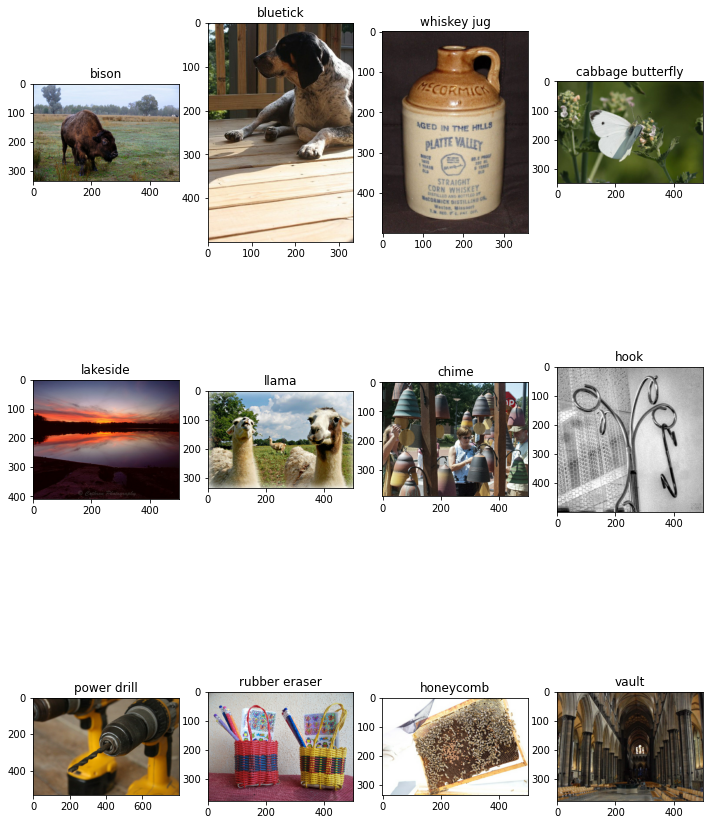

In [13]:
dir = list(data_root.glob('*/*'))
plt.figure(figsize = (12,16))
id = 1
for i in range(0, 120, 10):
  index = int((str(dir[i]).split('/'))[-2])+1
  img = tf.io.read_file(tf.constant(str(dir[i])))
  img = tf.image.decode_jpeg(img)
  img = tf.cast(img, tf.float64)/255.0
  plt.subplot(3,4,id)
  id += 1
  plt.imshow(img)
  plt.title(label[index])
plt.show()


In [264]:
roots = tf.data.Dataset.list_files(list(map(lambda x:str(x), dir)))

In [9]:
root_dir = (list(map(lambda x:str(x), dir)))

In [34]:
tf.data.Dataset.list_files(root_dir[0])

<ShuffleDataset shapes: (), types: tf.string>

In [12]:
real_dataset = tf.data.Dataset.list_files(root_dir[0])
real_dataset = real_dataset.map(lambda x:load_image_label(x, int(root_dir[0].split('/')[-2])+1))

In [11]:
def load_image_label(image, label):
  img = tf.io.read_file(image)
  img = tf.image.decode_jpeg(img)
  img = tf.cast(img, tf.float32)/255.0
  img = tf.image.resize(img, (224,224))
  img = tf.reshape(img, [-1,224,224,3])
  return img, label


- 아무리 그래도 image와 label이 묶인 tf.data.Dataset을 만들고 싶어서 여러 방법을 시도 해 보았는데, 제일 좋은 방법이 먼저 기본적인 틀이 담긴 readl_dataset을 하나 만들고 이후에 root_dir에 있는 저장경로를 이용해 하나씩 dataset을 만들며 이를 real_dataset에 합치는 것이 제일 좋을 것이라는 생각을 했다.
  - 그러나 메모리 부족에 의해서 제대로 작동을 하는지 확인은 못했지만 tensor의 형태의 directory를 string의 형태로 바꾸어 split할 수 가 없었기에 이 방법을 선택했다.
  - 그리고 zip()을 이용해 보려 했으나 이상하게 .take()함수를 사용하면 사용 할 때마다 이미지 데이터는 shuffle이 되는 지 계속 다른 값을 내보내는데 label데이터는 할 때마다 같은 값을 내보내었다.  

**항상 label의 데이터와 image의 데이터를 한꺼번에 묶어서 dataset으로 만드는 것은 class가 적을 경우에는 그렇게 어렵지 않은데 class가 많을 경우에는 조금 까다로운 것 같다.**
- 그러나 map()함수와 lambda x 함수를 잘 이용하면, 그리고 RAM 메모리가 충분하다면 가능한 작업이다.

In [13]:
for i in root_dir[1:]:
  dataset = tf.data.Dataset.list_files(i)
  dataset = dataset.map(lambda x: load_image_label(x, int(i.split('/')[-2])+1))
  real_dataset = real_dataset.concatenate(dataset)

In [279]:
for i in roots.take(1):
  print(str(i))
  print(int(str(i).split('/')[-2])+1)

tf.Tensor(b'/content/sample_data/datasets/imagenetv2-top-images-format-val/43/4.jpeg', shape=(), dtype=string)
44


In [306]:
import cv2
def load_image(image):
  img = tf.io.read_file(image)
  img = tf.image.decode_jpeg(img)
  img = tf.cast(img, tf.float64)/255.0
  img = tf.image.resize(img, (224,224))
  img = tf.reshape(img, [-1,224,224,3])
  return img


In [305]:
tags = tf.data.Dataset.(list(map(lambda x:int(str(x).split('/')[-2])+1,roots)))

In [260]:
len(roots)

10000

In [307]:
image_dataset = roots.map(load_image)
dataset = tf.data.Dataset.zip((image_dataset, tags))

In [309]:
for l,i in dataset.take(3):print(i)

tf.Tensor(115, shape=(), dtype=int32)
tf.Tensor(981, shape=(), dtype=int32)
tf.Tensor(386, shape=(), dtype=int32)


In [176]:
label[:10]

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen']

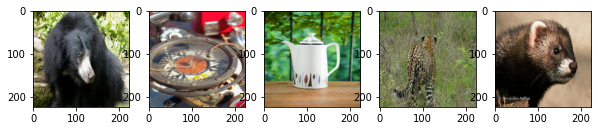

In [199]:
plt.figure(figsize = (10,10))
id = 1
for i in image_dataset.take(5):
  plt.subplot(1,5,id)
  id += 1
  i = tf.reshape(i, [224,224,3])
  plt.imshow(i)

In [ ]:
for i,l in dataset.take(10):
  print(i)

In [ ]:
plt.figure(figsize = (15,10))
id = 0
for i,l in real_dataset.take(10):
  plt.subplot(2,5,id+1)
  id += 1
  pred = np.argmax(model.predict(i))
  plt.imshow(tf.reshape(i, [224,224,3]))
  plt.title('{}:{}'.format(label[l.numpy()],label[pred]))

- 확실한 것은 처음에 predict를 해 주었을 때 너무 정확도가 낮고 제대로 분휴를 못했기 때문에 **사용하고자 하는 모델과 같은 형태의 데이터를 넣어야**한다는 것을 깨달았다. 
- image data를 255.0으로 나누어서 정규화한 상태를 이용해서 학습을 시킨 것이기 때문에 같은 상태여야 하고, shape또한 [None, 224, 224, 3]을 반드시 유지해야 한다.

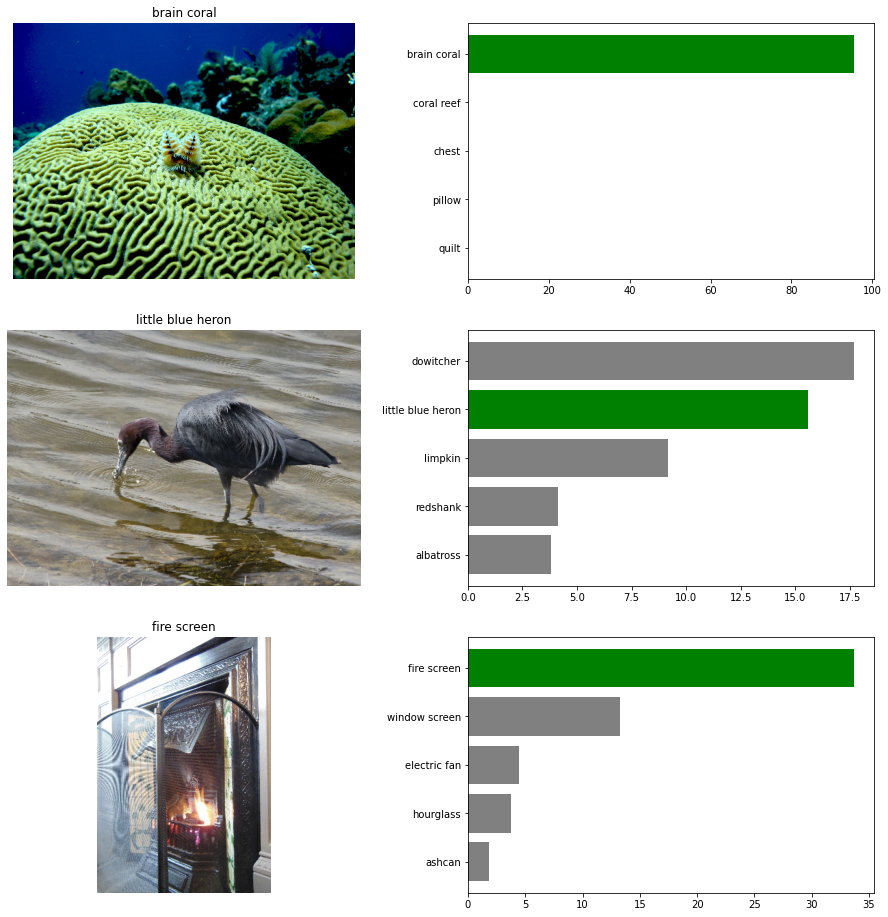

In [253]:
plt.figure(figsize = (16,16))
import random

def softmax(x):
  e_x = np.exp(x-np.max(x))
  return e_x / e_x.sum(axis = 0)

for i in range(3):
  image_path = random.choice(list(map(lambda x:str(x),list(data_root.glob('*/*')))))

  plt.subplot(3,2,i*2+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2])+1
  plt.title(label[idx])
  plt.axis('off')

  plt.subplot(3,2,i*2+2)
  #tensor의 형태이면 tf.io.read_file(image_path)를 한다. 단, image_path의 형태도 tensor의 형태여야 함
  img = cv2.imread(image_path)
  #tensor의 형태이면 tf.image.resize(img, (224,224))를 한다.
  img = cv2.resize(img,dsize = (224,224))
  img = img/255.0
  #tensor의 형태이면 tf.reshape([None, 224,224,3])을 한다
  img = np.expand_dims(img, axis = 0)

  pred = softmax(model.predict(img)[0])

  top_5_predict = pred.argsort()[::-1][:5]
  lab = [label[idx] for idx in top_5_predict]
  color = ['gray']*5
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]
  plt.barh(range(5), pred[top_5_predict][::-1]*100, color= color)
  plt.yticks(range(5), lab[::-1])

- np.argsort()는 값을 정렬하는 대신 인덱스를 정렬한다.
- 즉 [99,32,5,64]라는 numpy array가 있다면 이를 A라 할때 np.argsort(A)는 [2,1,3,0]이라는 값을 반환한다. 즉, A를 정렬한 후의 각 자리 수들의 정렬 전의 index를 array의 형태로 반환하게 되는 것이다.  

- 위의 랜덤하게 뽑은 세 이미지 중 총 2개는 Top-1예측을 맞추었고, 나머지 하나는 Top-2예측을 맞추었다.  

**이렇게 별도의 훈련 과정 없이도 미리 훈련된 모델을 tensorflow hub에서 불러와서 사용하는 것 만으로도 네트워크를 그대로 사용하여 예측만 확인 할 수 있다.**